# TREE SHAP on exported models (HARD)

In [1]:
import shap 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
from pickle import load

import matplotlib.pylab as pl
import matplotlib.pyplot as plt

import os
os.chdir("../lib/")
from get_transformer_feature_names import *

shap.initjs()

In [2]:
np.random.seed(0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
X_in = pd.read_csv("../data/input/mod1.csv", header = 0,index_col = 0)
y_hard = pd.read_csv("../data/input/outcomehard.csv", header = 0, index_col = 0)

num_feat = pd.read_csv("../data/input/numeric_features.csv", header=0)
cat_feat = pd.read_csv("../data/input/categorical_features.csv", header=0)

mod1_hard = load(open("../data/output/outcome_hard/mod1/ss_only/rf_hard_mod1.pkl", "rb"))

In [4]:
X_in=X_in.sort_index(axis=0)
y_hard = y_hard.sort_index(axis = 0)

In [5]:
# separate the model steps 
prep = mod1_hard.named_steps['preprocessor']
mod = mod1_hard.named_steps['rf']

In [6]:
mod #these are the params

RandomForestClassifier(max_features=0.6000000000000002,
                       max_samples=0.15000000000000002, n_estimators=250,
                       n_jobs=-1, oob_score=True, random_state=0,
                       warm_start=True)

In [7]:
#transform the x data 
X_trans = prep.fit_transform(X_in)

In [8]:
preds = mod.predict_proba(X_trans)

In [9]:
feature_names = get_transformer_feature_names(prep)

In [10]:
shap_values = shap.TreeExplainer(mod).shap_values(X_trans) #the model was already re-fit to the entire data set as the last step of gridsearch CV
#note that I also tested this by running TreeExplainer on the mod after fitting to X_trans and got the same shapely values

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [11]:
explainer = shap.TreeExplainer(mod)

Each row sums to the difference between the model output for that
        sample and the expected value of the model output (which is stored in the expected_value
        attribute of the explainer when it is constant). 

In [12]:
#row sums for subj 0 
shap_values[0][0].sum(0)

-0.04189473684210529

In [13]:
print(preds[0,0]) #this is the prediction for subj 0, class 0 
print(explainer.expected_value[0]) #expected valuef or class 0
print(preds[0,0] - explainer.expected_value[0]) #the diff between the model output and the expected value. should match the above value

0.648
0.6898947368421051
-0.041894736842105096


# Overall Shapely Values 
0 == Not hard and 1 == hard
average of the SHAP value magnitude

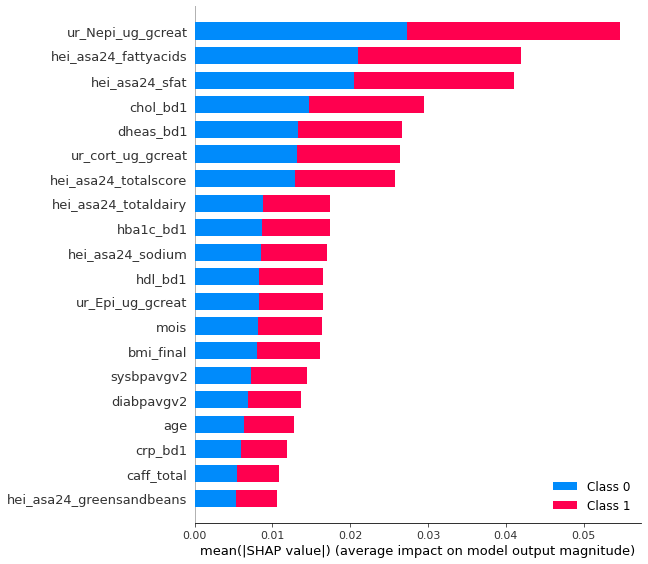

In [14]:
shap.summary_plot(shap_values, X_trans, feature_names = feature_names)

## Dot Plot

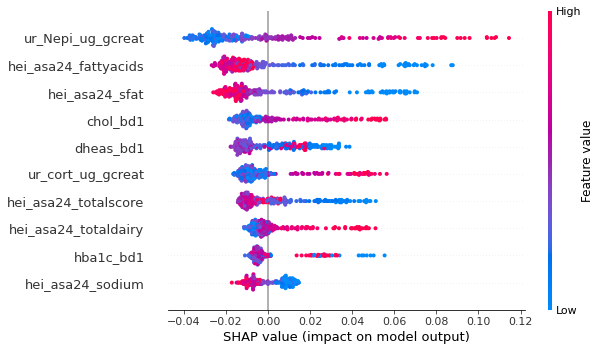

In [15]:
## Class 1 (hard)
shap.summary_plot(shap_values[1],X_trans, 
                 feature_names = feature_names, plot_type = 'dot', show = False)
#plt.savefig('../plots/shap/outcome_hard/outcome_hard_1.pdf',format='pdf', dpi=1000, bbox_inches='tight')
#plt.savefig('../plots/shap/outcome_hard/outcome_hard_1_tiny.pdf',format='pdf', dpi=1000, bbox_inches='tight') #when max_display = 10

In [66]:
shap_values0 = pd.DataFrame(shap_values[0], columns = feature_names, index = X_in.index)
shap_values1 = pd.DataFrame(shap_values[1], columns = feature_names, index = X_in.index)

In [67]:
file0 = "hard0_shapvals.csv"
file1 = "hard1_shapvals.csv"
path = "../data/output/shap/outcome_hard/"

In [68]:
shap_values0.to_csv(path + file0, index = True)
shap_values1.to_csv(path + file1, index = True)